# Image Compression Using Haar-based Discrete Wavelet Transform(DWT)

In [1]:
# import the required packages
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d

## Defines wavelet filters with different tap lengths

In [2]:
# Define the filters for Tap 2
h_tap2 = 1/np.sqrt(2) * np.array([1, 1])
g_tap2 = 1/np.sqrt(2) * np.array([1, -1])

# Define the filters for Tap 4
h_tap4 = 1/np.sqrt(2) * np.array([0.6830127, 1.1830127, 0.3169873, -0.1830127])
g_tap4 = 1/np.sqrt(2) * np.array([0.1830127, 0.3169873, -1.1830127, 0.6830127])

# Define the filters for Tap 6
h_tap6 = 1/np.sqrt(2) * np.array([0.47046721, 1.14111692, 0.650365, -0.19093442, -0.12083221, 0.0498175])
g_tap6 = 1/np.sqrt(2) * np.array([-0.0498175, -0.12083221, 0.19093442, 0.650365, -1.14111692, 0.47046721])

# For the 2D filters, we need to take the outer product of the vectors based on the definition
H_tap2 = np.outer(h_tap2, h_tap2)
G1_tap2 = np.outer(h_tap2, g_tap2)
G2_tap2 = np.outer(g_tap2, h_tap2)
G3_tap2 = np.outer(g_tap2, g_tap2)

H_tap4 = np.outer(h_tap4, h_tap4)
G1_tap4 = np.outer(h_tap4, g_tap4)
G2_tap4 = np.outer(g_tap4, h_tap4)
G3_tap4 = np.outer(g_tap4, g_tap4)

H_tap6 = np.outer(h_tap6, h_tap6)
G1_tap6 = np.outer(h_tap6, g_tap6)
G2_tap6 = np.outer(g_tap6, h_tap6)
G3_tap6 = np.outer(g_tap6, g_tap6)

# Create a dictionary to store the filters
H ={2: H_tap2, 4: H_tap4, 6: H_tap6}
G1 ={2: G1_tap2, 4: G1_tap4, 6: G1_tap6}
G2 ={2: G2_tap2, 4: G2_tap4, 6: G2_tap6}
G3 ={2: G3_tap2, 4: G3_tap4, 6: G3_tap6}

# Create a dictionary to store the filters in reverse order
H_rev={2: H_tap2[::-1,::-1], 4: H_tap4[::-1,::-1], 6: H_tap6[::-1,::-1]}
G1_rev={2: G1_tap2[::-1,::-1], 4: G1_tap4[::-1,::-1], 6: G1_tap6[::-1,::-1]}
G2_rev={2: G2_tap2[::-1,::-1], 4: G2_tap4[::-1,::-1], 6: G2_tap6[::-1,::-1]}
G3_rev={2: G3_tap2[::-1,::-1], 4: G3_tap4[::-1,::-1], 6: G3_tap6[::-1,::-1]}


## define the transform function

In [3]:
def dwt2d(im, lvl, tap):
# Computing 2D discrete Haar wavelet transform of a given ndarray im.
# Parameters: 
#   im: ndarray.    An array representing image
#   lvl: integer.   An integer representing the level of wavelet decomposition
#   tap: integer.   An integer representing the tap of the wavelet filter
#  Returns:
#   out: ndarray.   An array representing  wavelet coefficients with lvl level. It has the same shape as im

    out = np.zeros([len(im), len(im)])
    
    # loop for number of levels
    for i in range(lvl):
        # convolve the image with the corresponding reversed filters, then downsample the image by 2
        s = convolve2d(im, H_rev[tap], mode='same', boundary='wrap')[1::2, 1::2]
        w1 = convolve2d(im, G1_rev[tap], mode='same', boundary='wrap')[1::2, 1::2]
        w2 = convolve2d(im, G2_rev[tap], mode='same', boundary='wrap')[1::2, 1::2]
        w3 = convolve2d(im, G3_rev[tap], mode='same', boundary='wrap')[1::2, 1::2]
        # store the coefficients in the corresponding position
        out[0:len(im)//2 , 0:len(im)//2] = s 
        out[0:len(im)//2 , len(im)//2:len(im)] = w1
        out[len(im)//2:len(im) , 0:len(im)//2] = w2
        out[len(im)//2:len(im) , len(im)//2:len(im)] = w3
        # update the image for the next level
        im = s


    return out

## Define the inverse transform function

In [4]:
def idwt2d(coef, lvl, tap):
# Computing an image in the form of ndarray from the ndarray coef which represents its DWT coefficients.
# Parameters: 
#   coef: ndarray   An array representing 2D Haar wavelet coefficients
#   lvl: integer.   An integer representing the level of wavelet decomposition
#   tap: integer.   An integer representing the tap of the wavelet filter
#  Returns:
#   out: ndarray.   An array representing the image reconstructed from its  wavelet coefficients.

    out = coef.copy()
    # the length of the coefficients for the first level
    coef_len = len(out)//2**(lvl-1)
    # loop for number of levels
    for i in range(lvl):
        # extract the coefficients for the current level
        n_lvl_coef = out[0:coef_len, 0:coef_len]
        coef_len = len(n_lvl_coef)
        s = np.zeros([coef_len, coef_len])
        w1 = np.zeros([coef_len, coef_len])
        w2 = np.zeros([coef_len, coef_len])
        w3 = np.zeros([coef_len, coef_len])
        # reconstruct the image by upsampling and convolving with the corresponding filters
        s[0::2, 0::2] = n_lvl_coef[0:len(n_lvl_coef)//2, 0:len(n_lvl_coef)//2]
        w1[0::2, 0::2] = n_lvl_coef[0:len(n_lvl_coef)//2, len(n_lvl_coef)//2:len(n_lvl_coef)]
        w2[0::2, 0::2] = n_lvl_coef[len(n_lvl_coef)//2:len(n_lvl_coef), 0:len(n_lvl_coef)//2]
        w3[0::2, 0::2] = n_lvl_coef[len(n_lvl_coef)//2:len(n_lvl_coef), len(n_lvl_coef)//2:len(n_lvl_coef)]
        s_recon = convolve2d(s, H[tap], mode='same', boundary='wrap')
        s_recon += convolve2d(w1, G1[tap], mode='same', boundary='wrap')
        s_recon += convolve2d(w2, G2[tap], mode='same', boundary='wrap')
        s_recon += convolve2d(w3, G3[tap], mode='same', boundary='wrap')
        
        out[0:coef_len, 0:coef_len] = s_recon
        coef_len = coef_len*2
    # convert the image to uint8 for saving in the correct format
    out = out.astype(np.uint8)
    return out

## Visualizing the effect

### Original test image

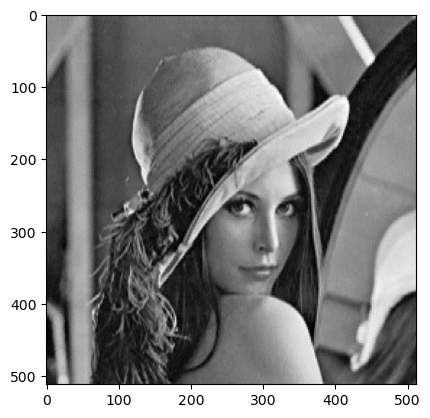

In [46]:
# Open the image that is required to be processed on using PIL
im = np.array(Image.open('test_image.png'))

# Plot image for viewing, gray-scale image
plt.subplot(1,1,1); plt.imshow(im, cmap='gray')

### Compressed test image

In [70]:
haar2d_coef = dwt2d(im, 2, 2)

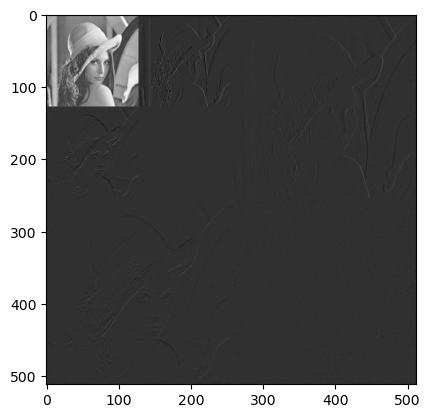

In [71]:
plt.imshow(haar2d_coef,cmap='gray')

### Reconstructed test image

In [74]:
recon_image = idwt2d(haar2d_coef, 2, 2)

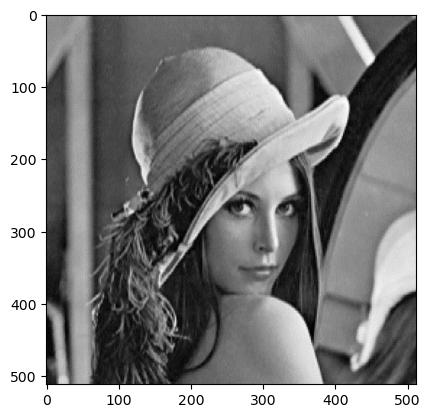

In [75]:
plt.imshow(recon_image, cmap='gray')

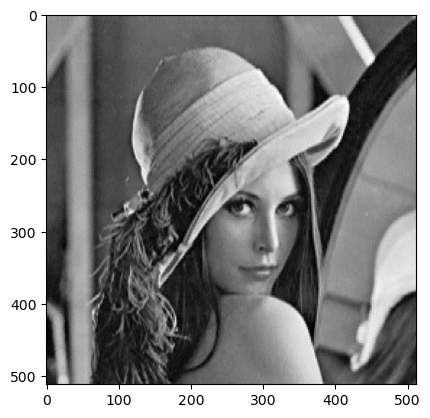

In [59]:
plt.imshow(im, cmap='gray')